# Surface Photometry Using GALFIT

Multi-component galaxy modeling using GALFIT typically involves the following steps:

1. Prepare the input data: The first step is to prepare the input data for GALFIT. This involves selecting the image(s) to be modeled, determining the PSF (point spread function) of the instrument, and creating a mask to exclude regions that should not be included in the model.
   
2. Initialize the model: The next step is to initialize the model parameters in GALFIT. This involves specifying the number and type of components to be included in the model (e.g., bulge, disk, bar, etc.), and setting the initial values of the model parameters (e.g., position, size, brightness, etc.).
   
3. Run the fitting process: Once the model is initialized, GALFIT can be used to fit the model to the input data. This involves minimizing the chi-squared statistic between the model and the data, using an iterative algorithm to adjust the model parameters.
   
4. Evaluate the fit: After the fitting process is complete, it is important to evaluate the quality of the fit. This can be done by examining the residuals (i.e., the difference between the data and the model), as well as the goodness-of-fit statistics provided by GALFIT (e.g., reduced chi-squared, Akaike Information Criterion, Bayesian Information Criterion, etc.).
   
5. Refine the model: Based on the evaluation of the fit, it may be necessary to refine the model by adjusting the model parameters and/or the mask. This process may need to be repeated several times until an acceptable fit is achieved.

6. Extract results: Once an acceptable fit is achieved, the final model parameters can be extracted from GALFIT and used to generate images or other data products that represent the modeled galaxy. These results can be used for further analysis and interpretation of the observed galaxy.

# 1. Prepare the Input Data
## Download SDSS Mosaic Image from SDSS Science Archive Server (SAS)

* Web link: [Imaging Mosaics](https://dr12.sdss.org/mosaics)

![](./data/proj4/1.png)

Fill out the RA and Dec information, and resulting angluar size of the image.
Then click the "Submit" button.

![](./data/proj4/2.png)

Click "Click here to download ~" to get the shell file.

Before you create the mosaic image you have to install `SWarp` package.

If you use Anaconda environment (check your current environment before the installation),
```shell
$ conda install -c conda-forge astromatic-swarp
```

Otherwise you need to install by following [the official website](https://www.astromatic.net/software/swarp/) which I didn't test.


* Useful Resources (If you want to evaluate errors pixel by pixel)
  * [Description of SDSS Imaging Data Files](https://www.sdss4.org/dr16/imaging/images/)
  * [FITS Structure for Corrected Frame](https://data.sdss.org/datamodel/files/BOSS_PHOTOOBJ/frames/RERUN/RUN/CAMCOL/frame.html)

***

## M51

In this tutorial, we conduct surface photometry of M51, whose image is downloaded
from the archival data of SDSS, to reproduce Figure 21. (see below figure) of [Peng et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010AJ....139.2097P/abstract).

![](./data/proj4/3.png)

Let's make mosaic of M51 field, with the image size of $18'$.
The r-band images of single fields for the mosaics are queried from the above
process, with the RA=202.446521667, Dec=47.2273441667, Image Size=0.3.

We make the mosaic image executing the shell file.

```shell
$ cd <Move To Path Where The Shell File Exists>
$ chmod 744 <Your Shell File>
$ ./<Your Shell File>
```

Here, for example,
```shell
$ cd data/proj4
$ chmod 744 J132947.00+471338.0.sh
$ ./J132947.00+471338.0.sh
```

Then you will get `J132947.00+471338.0-r.fits` and `J132947.00+471338.0-r.weight.fits`,
the r-band image and its weight image.


In [1]:
import os
from pathlib import Path

os.chdir('./data/proj4')
cwd = Path.cwd()
cwd

PosixPath('/Users/hbahk/class/tao23/TAO23/tutorials/data/proj4')

In [2]:
name = 'J132947.00+471338.0'

if not (cwd/'input').exists():
    (cwd/'input').mkdir()

os.system(f'chmod 744 {name}.sh')
os.system(f'./{name}.sh')
os.system('rm *.bz2')

rm: *.bz2: No such file or directory


256

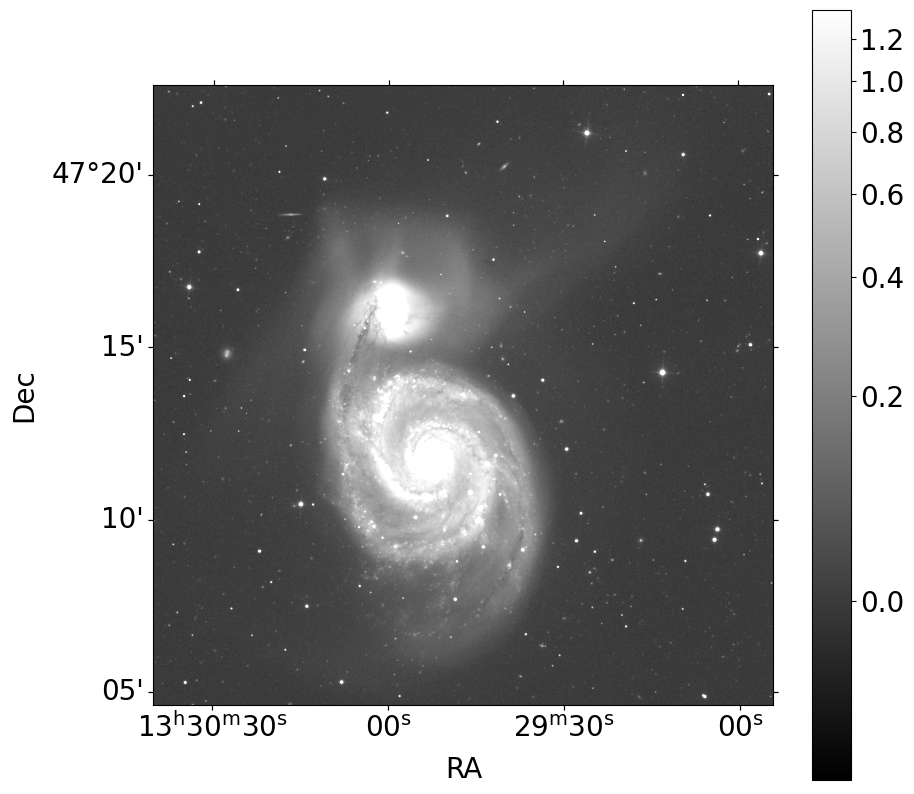

In [3]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import AsymmetricPercentileInterval, AsinhStretch, ImageNormalize
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 20

hdu = fits.open(cwd/f'{name}-r.fits')
image = hdu[0].data
wcs = WCS(hdu[0].header)

norm = ImageNormalize(image, interval=AsymmetricPercentileInterval(0., 99.0), stretch=AsinhStretch())
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(image, cmap='gray', origin='lower', norm=norm)
fig.colorbar(im)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')


The detector gain of SDSS images differ by the camera column (CAMCOL) and the
bands (u, g, r, i, z). To know the gain of the image, we need to check the
table from the bottom page of this link: [FITS Structure for Corrected Frame](https://data.sdss.org/datamodel/files/BOSS_PHOTOOBJ/frames/RERUN/RUN/CAMCOL/frame.html)
For example, the gain of CAMCOL=1 CCD in r-band is 4.71.
Since the gain is not provided in the header of the corrected frames, `Swarp`
package doesn't provide the average effective gain as usual.

Let's make error images following the guideline provided in [FITS Structure for Corrected Frame](https://data.sdss.org/datamodel/files/BOSS_PHOTOOBJ/frames/RERUN/RUN/CAMCOL/frame.html).

In [4]:
frames = sorted(cwd.glob('frame*[0-9].fits'))

from scipy.interpolate import RegularGridInterpolator

frame = frames[0]
fhdu = fits.open(frame)
img = fhdu[0].data
sky = fhdu[2].data
allsky = sky['ALLSKY'][0].astype(float)
# be careful with the order of the axes
SX, SY = np.meshgrid(sky['XINTERP'][0].astype(float), sky['YINTERP'][0].astype(float))
gridx, gridy = np.arange(allsky.shape[1]), np.arange(allsky.shape[0])
sinterp = RegularGridInterpolator((gridy, gridx), allsky, method='linear',
                                  bounds_error=False, fill_value=None)
simg = sinterp((SY, SX))


In [5]:
SX # x-axis corresponds to the axis=1, the columns of the image

array([[-4.375000e-01, -3.125000e-01, -1.875000e-01, ...,  2.551875e+02,
         2.553125e+02,  2.554375e+02],
       [-4.375000e-01, -3.125000e-01, -1.875000e-01, ...,  2.551875e+02,
         2.553125e+02,  2.554375e+02],
       [-4.375000e-01, -3.125000e-01, -1.875000e-01, ...,  2.551875e+02,
         2.553125e+02,  2.554375e+02],
       ...,
       [-4.375000e-01, -3.125000e-01, -1.875000e-01, ...,  2.551875e+02,
         2.553125e+02,  2.554375e+02],
       [-4.375000e-01, -3.125000e-01, -1.875000e-01, ...,  2.551875e+02,
         2.553125e+02,  2.554375e+02],
       [-4.375000e-01, -3.125000e-01, -1.875000e-01, ...,  2.551875e+02,
         2.553125e+02,  2.554375e+02]])

Text(0.5, 1.0, 'Reconstructed Sky Image')

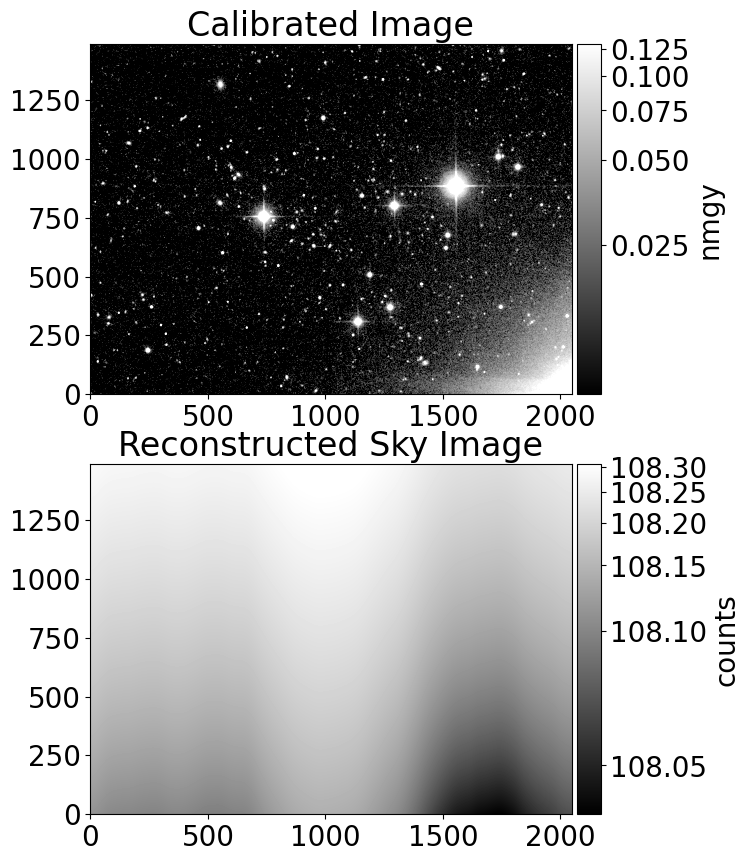

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

inorm = ImageNormalize(img, interval=AsymmetricPercentileInterval(50, 99.0), stretch=AsinhStretch())
snorm = ImageNormalize(simg, interval=AsymmetricPercentileInterval(0., 99.0), stretch=AsinhStretch())

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

im = ax.imshow(img, cmap='gray', origin='lower', norm=inorm)
im_sky = ax2.imshow(simg, cmap='gray', origin='lower', norm=snorm)

divider = make_axes_locatable(ax)
divider2 = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, label='nmgy')
fig.colorbar(im_sky, cax=cax2, label='counts')

ax.set_title('Calibrated Image')
ax2.set_title('Reconstructed Sky Image')

Text(0.5, 1.0, 'Calibration Image')

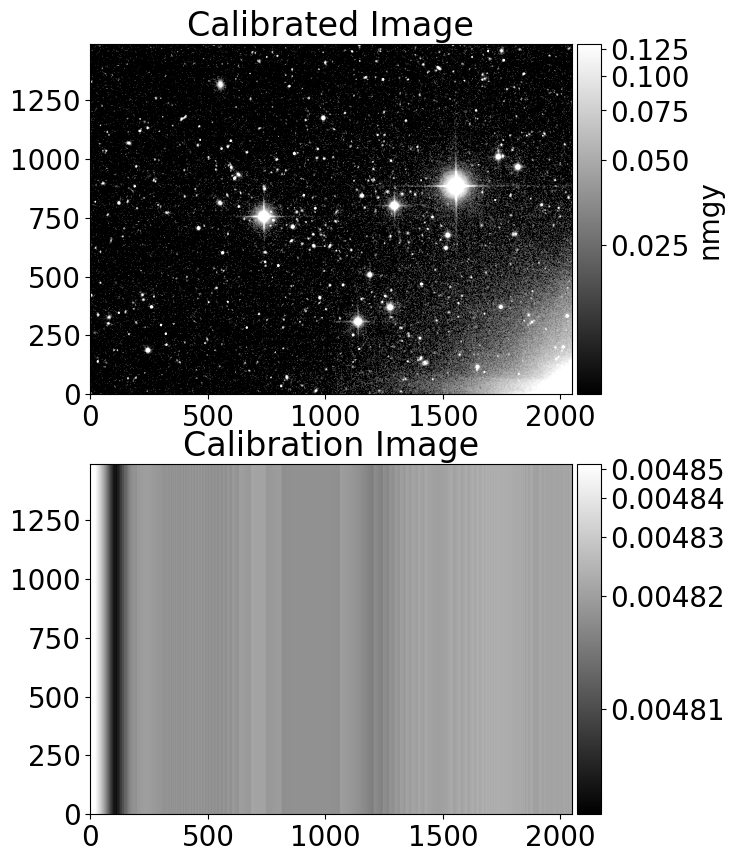

In [7]:
calib = fhdu[1].data
nrowc = len(img)
cimg = calib*np.ones((nrowc, len(calib)))

inorm = ImageNormalize(img, interval=AsymmetricPercentileInterval(50, 99.0), stretch=AsinhStretch())
cnorm = ImageNormalize(cimg, interval=AsymmetricPercentileInterval(0., 99.0), stretch=AsinhStretch())

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

im = ax.imshow(img, cmap='gray', origin='lower', norm=inorm)
im_cal = ax2.imshow(cimg, cmap='gray', origin='lower', norm=cnorm)

divider = make_axes_locatable(ax)
divider2 = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, label='nmgy')
fig.colorbar(im_cal, cax=cax2)

ax.set_title('Calibrated Image')
ax2.set_title('Calibration Image')

Text(0.5, 1.0, 'Calibration Error Image')

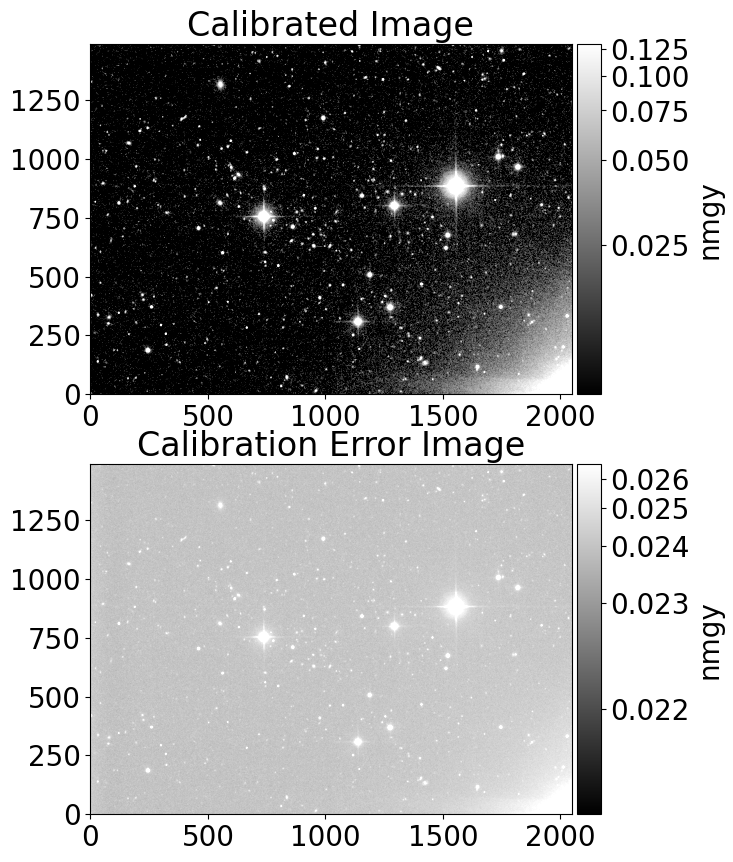

In [8]:
dn = img/cimg + simg # count unit

# dictionary for gain and dark variance of r-band
dict_gain_r = {'1': 4.71, '2':4.6, '3':4.72, '4':4.76, '5':4.725, '6':4.895}
dict_darkvar_r = {'1': 1.8225, '2':1.00, '3':1.3225, '4':1.3225, '5':0.81, '6':0.9025}

camcol = frame.stem.split('-')[-2] # read camcol in the filename
gain = dict_gain_r[camcol]
darkvar = dict_darkvar_r[camcol]

# error map in count
dn_err = np.sqrt(dn/gain + darkvar)

img_err = dn_err*cimg # error map in nmgy

# plot flux and error map
inorm = ImageNormalize(img, interval=AsymmetricPercentileInterval(50, 99.0), stretch=AsinhStretch())
enorm = ImageNormalize(img_err, interval=AsymmetricPercentileInterval(0., 99.0), stretch=AsinhStretch())

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

im = ax.imshow(img, cmap='gray', origin='lower', norm=inorm)
im_cal = ax2.imshow(img_err, cmap='gray', origin='lower', norm=enorm)

divider = make_axes_locatable(ax)
divider2 = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, label='nmgy')
fig.colorbar(im_cal, cax=cax2, label='nmgy')

ax.set_title('Calibrated Image')
ax2.set_title('Calibration Error Image')

In [9]:
def get_sdss_r_errimg(frame):
    fhdu = fits.open(frame)
    hdr = fhdu[0].header
    img = fhdu[0].data
    
    # sky reconstruction
    sky = fhdu[2].data
    allsky = sky['ALLSKY'][0].astype(float)
    SX, SY = np.meshgrid(sky['XINTERP'][0].astype(float), sky['YINTERP'][0].astype(float))
    gridx, gridy = np.arange(allsky.shape[1]), np.arange(allsky.shape[0])
    sinterp = RegularGridInterpolator((gridy, gridx), allsky, method='linear',
                                    bounds_error=False, fill_value=None)
    simg = sinterp((SY, SX))
    
    # calibration image
    calib = fhdu[1].data
    nrowc = len(img)
    cimg = calib*np.ones((nrowc, len(calib)))
    
    dn = img/cimg + simg # count unit

    # dictionary for gain and dark variance of r-band
    # https://data.sdss.org/datamodel/files/BOSS_PHOTOOBJ/frames/RERUN/RUN/CAMCOL/frame.html
    dict_gain_r = {'1': 4.71, '2':4.6, '3':4.72, '4':4.76, '5':4.725, '6':4.895}
    dict_darkvar_r = {'1': 1.8225, '2':1.00, '3':1.3225, '4':1.3225, '5':0.81, '6':0.9025}

    camcol = frame.stem.split('-')[-2] # read camcol in the filename
    gain = dict_gain_r[camcol]
    darkvar = dict_darkvar_r[camcol]

    # error map in count
    dn_err = np.sqrt(dn/gain + darkvar)

    img_err = dn_err*cimg # error map in nmgy
    
    return img_err, hdr

for frame in frames:
    eimg, hdr = get_sdss_r_errimg(frame)
    # save error image
    ivhdu = fits.PrimaryHDU(1/eimg**2, header=hdr)
    ivhdu.writeto(frame.parent.joinpath(frame.stem+'.ivar.fits'), overwrite=True)
    

In [10]:
# add gain to header
for frame in frames:
    fhdu = fits.open(frame)
    dict_gain_r = {'1': 4.71, '2':4.6, '3':4.72, '4':4.76, '5':4.725, '6':4.895}
    dict_darkvar_r = {'1': 1.8225, '2':1.00, '3':1.3225, '4':1.3225, '5':0.81, '6':0.9025}

    camcol = frame.stem.split('-')[-2] # read camcol in the filename
    gain = dict_gain_r[camcol]
    fhdu[0].header['GAIN'] = gain
    
    fhdu.writeto(frame, overwrite=True)

In [11]:
# mosaic images again and make a mosaic of the ivar images
str_eframes = ' '.join([str(frame.stem)+'.ivar.fits\[0\]' for frame in frames])
str_frames = ' '.join([str(frame.stem)+'.fits' for frame in frames])
os.system('swarp '+str_frames)
os.system('swarp '+str_eframes+f' -IMAGEOUT_NAME {name}-r.ivar.fits -WEIGHTOUT_NAME {name}-r.err.weight.fits')
# 'swarp '+str_frames+' -c default.swarp -WEIGHT_TYPE MAP_RMS -WEIGHT_SUFFIX .err.fits\[0\] -RESCALE_WEIGHTS N'

0

In [12]:
# get sigma image from ivar image
DIR_INPUT = 'input'
if not (cwd/DIR_INPUT).exists():
    (cwd/DIR_INPUT).mkdir()

iehdu = fits.open(f'{name}-r.ivar.fits')
ieimg = iehdu[0].data
eimg = 1/np.sqrt(ieimg)
ehdu = fits.PrimaryHDU(eimg, header=iehdu[0].header)
ehdu.writeto(cwd/DIR_INPUT/f'sigma_{name}-r.fits', overwrite=True)

# galfit takes nmagy as count and devide the exposure time to calculate the magnitude
hdu[0].header['EXPTIME'] = 1.0

hdu.writeto(cwd/DIR_INPUT/f'input_{name}-r.fits', overwrite=True)

## Getting PSF


Since we need PSF to use GALFIT, we will get PSF of the image using the PSFEx software. If you want more
information about PSFEx, please check this link: [Getting Started](https://psfex.readthedocs.io/en/latest/GettingStarted.html)


In [13]:
# Aperture size for SExtractor run
FACTOR = 1
PHOT_APERTURE = 10*FACTOR # in arcsec
SCALE = 0.396127*FACTOR # arcsec/pixel
PHOT_APERTURE_PIX = round(PHOT_APERTURE/SCALE)
print(SCALE, PHOT_APERTURE_PIX)

0.396127 25


In [14]:
# SExtractor parameter file setting
param_name = "output.param"
f = open(param_name, "w")
f.write("X_IMAGE\n")         # Object position along x [pixel]
f.write("Y_IMAGE\n")         # Object position along y [pixel]
f.write(f"VIGNET({PHOT_APERTURE_PIX},{PHOT_APERTURE_PIX})\n")  # Pixel data around detection [count]
f.write("FLUX_RADIUS\n")     # Half-light radii
f.write("SNR_WIN\n")         # Gaussian-weighted SNR
f.write("FLUX_APER(1)\n")    # Flux vector within fixed circular aperture(s) [count]
f.write("FLUXERR_APER(1)\n") # RMS error vector for aperture flux(es) [count]
f.write("ELONGATION\n")      # A_IMAGE/B_IMAGE
f.write("FLAGS\n")           # Extraction flags
f.close()

In [15]:
# SExtractor run to feed PSFEx
PATH_CONV = '/opt/homebrew/opt/sextractor/share/sextractor/default.conv'
PATH_NNW = '/opt/homebrew/opt/sextractor/share/sextractor/default.nnw'

catalog_name = f'{name}-r.cat'

exec_sextractor = f'sex {name}-r.fits -c default.sex' + \
    f' -CATALOG_NAME {catalog_name}' + \
    f' -PARAMETERS_NAME {param_name}' + \
    f' -FILTER_NAME {PATH_CONV}' + \
    f' -CATALOG_TYPE FITS_LDAC -PHOT_APERTURES {round(PHOT_APERTURE/SCALE)}' 

os.system('sex -d >> default.sex')
os.system(exec_sextractor)


> 
----- SExtractor 2.28.0 started on 2023-05-14 at 23:26:34 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for J132947.00+471338.0-r.fits
----- Measuring from: J132947.00+471338.0-r.fits
      "30 N" / no ext. header / 2726x2726 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up background map at line:  832
> Setting up background map at line:  896
> Setting up background map at line:  960
> Sett

0

In [16]:
# PSFEx run
config_psfex = 'config.psfex'
os.system(f'psfex -d >> {config_psfex}')
os.system(f'psfex {catalog_name} -c {config_psfex}')


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.2 started on 2023-05-14 at 23:26:37 with 8 threads

> 
----- 1 input catalogues:
J132947.00+471338.0-:  "30 N            "    1 extension    2262 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from J132947.00+471338.0-r...
> Computing final PSF model for J132947.00+471338.0-r...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for J132947.00+471338.0-r...
J132947.00+471338           82/104     0.83   0.87   3.22  0.01  0.02  0.04
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Saving PSF model and metadata for J132947.00+471338.0-r...
> Writing XML file...
> 
> All done (in 0.0 s)


0

We obtained `J132947.00+471338.0-r.psf`!

In [17]:
phdu = fits.open(f'{name}-r.psf')
fwhm = phdu[1].header['PSF_FWHM']
print('PSF_FWHM:', fwhm)
phdu.info()
phdu[1].header

PSF_FWHM: 3.88474584
Filename: J132947.00+471338.0-r.psf
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PSF_DATA      1 BinTableHDU     32   1R x 1C   [3750E]   


XTENSION= 'BINTABLE'           / THIS IS A BINARY TABLE (FROM THE LDACTOOLS)    
BITPIX  =                    8 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                15000 / BYTES PER ROW                                  
NAXIS2  =                    1 / NUMBER OF ROWS                                 
PCOUNT  =                    0 / RANDOM PARAMETER COUNT                         
GCOUNT  =                    1 / GROUP COUNT                                    
TFIELDS =                    1 / FIELDS PER ROWS                                
EXTNAME = 'PSF_DATA'           / TABLE NAME                                     
LOADED  =                  104 / Number of loaded sources                       
ACCEPTED=                   82 / Number of accepted sources                     
CHI2    =           0.87119488 / Final reduced chi2                             
POLNAXIS=                   

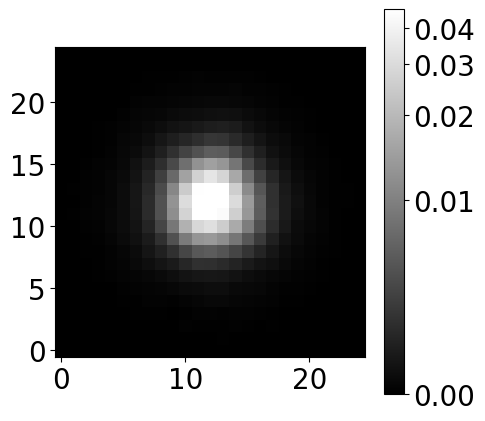

In [18]:
# Inspect the PSF image (at the center of the image)
image_psf = phdu[1].data['PSF_MASK'][0][0]
norm_psf = ImageNormalize(image_psf, interval=AsymmetricPercentileInterval(0., 99.0), stretch=AsinhStretch())

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
pim = ax.imshow(image_psf, cmap='gray', origin='lower', norm=norm_psf)
fig.colorbar(pim)

# Save the PSF image
hdu_psf = fits.PrimaryHDU(image_psf)
hdu_psf.writeto(cwd/DIR_INPUT/f'psf_{name}-r.fits', overwrite=True)

## Making the Mask Image

Let's obtain the celestial coordinates (RA and DEC) of two objects, M51A and M51B, from the NASA/IPAC Extragalactic Database (NED). From this positions, we will
determine the center coordinate pixels for each galaxy, and construct models
individually.

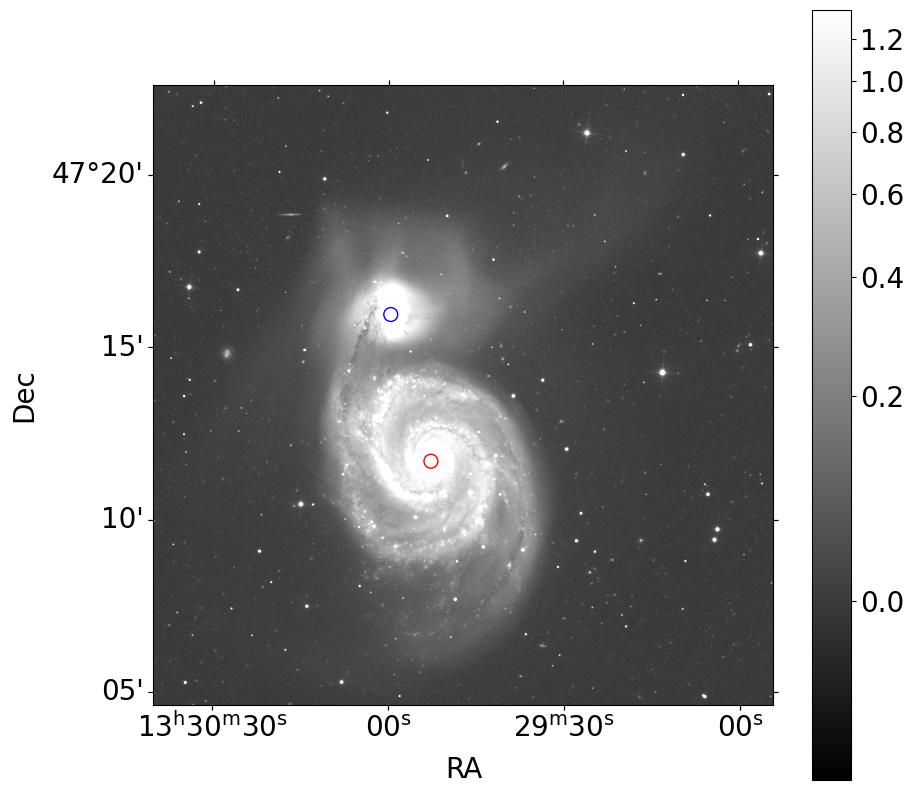

In [19]:
from astroquery.ipac.ned import Ned
ra_a, dec_a = Ned.query_object("M51A")['RA', 'DEC'][0]
ra_b, dec_b = Ned.query_object("M51B")['RA', 'DEC'][0]

x_a, y_a = wcs.all_world2pix(ra_a, dec_a, 0)
x_b, y_b = wcs.all_world2pix(ra_b, dec_b, 0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(image, cmap='gray', origin='lower', norm=norm)
fig.colorbar(im)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.scatter(x_a, y_a, marker='o', s=100, facecolors='none', edgecolors='r')
ax.scatter(x_b, y_b, marker='o', s=100, facecolors='none', edgecolors='b')

Two red and blue circular markers are plotted on the image at the pixel coordinates of M51A and M51B, respectively.


In [20]:
from photutils.segmentation import detect_sources
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
# from photutils.detection import DAOStarFinder

bkg_estimator = MedianBackground()
bkg = Background2D(image, (100, 100), filter_size=(5, 5), bkg_estimator=bkg_estimator)
threshold = 1.0*bkg.background_rms

kernel = make_2dgaussian_kernel(fwhm*3, size=15)
convolved_data = convolve(image, kernel)

segment_map = detect_sources(convolved_data, threshold, npixels=10)
print(segment_map)

label_main = segment_map.data[int(y_a), int(x_a)]
orig_seg = segment_map.copy()
segment_map.remove_labels([label_main])

mask = np.nonzero(segment_map.data)
masked_image = image.copy()
masked_image[mask] = -1
    
mask_image = np.zeros_like(image)
mask_image[mask] = 1

# # additional masking
# daofind = DAOStarFinder(fwhm=fwhm, threshold=np.median(threshold))
# stars = daofind(masked_image, mask=orig_seg.data.astype(bool))

# hw = 2
# for star in stars:
#     x, y = int(star['xcentroid']), int(star['ycentroid'])
#     mask_image[y-hw:y+hw+1, x-hw:x+hw+1] = 0
#     masked_image[y-hw:y+hw+1, x-hw:x+hw+1] = -1

<photutils.segmentation.core.SegmentationImage>
shape: (2726, 2726)
nlabels: 647
labels: [  1   2   3   4   5 ... 643 644 645 646 647]


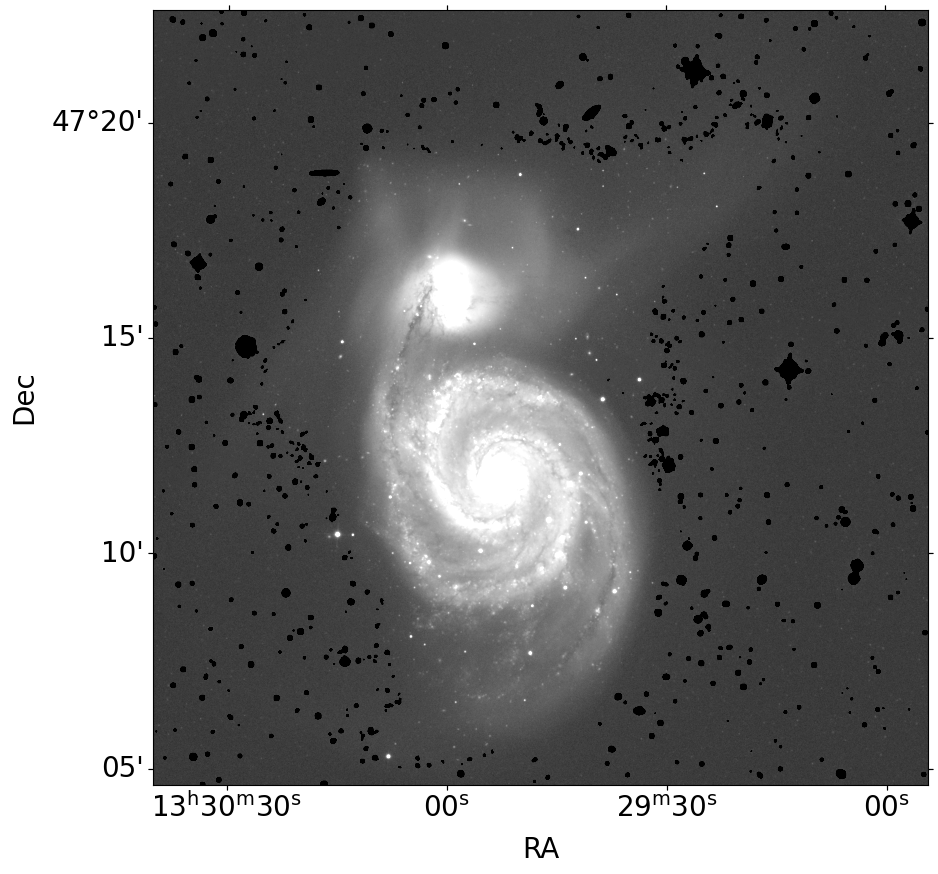

In [21]:

fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(masked_image, cmap='gray', origin='lower', norm=norm)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')


In [22]:
# Save the mask image
hdu_mask = fits.PrimaryHDU(mask_image)
hdu_mask.writeto(cwd/DIR_INPUT/f'mask_{name}-r.fits', overwrite=True)

# Initialize Model and Run GALFIT

All the information you need is contained in [GALFIT User Manual](https://users.obs.carnegiescience.edu/peng/work/galfit/README.pdf)(see Section 7 and 8)!


Now Let's construct the input file. Below is an example input file ([you can find it from here](https://users.obs.carnegiescience.edu/peng/work/galfit/example2)), which includes
all possible funtional type and basic information about them.
```
================================================================================
# IMAGE and GALFIT CONTROL PARAMETERS
A) gal.fits            # Input data image (FITS file)
B) imgblock.fits       # Output data image block
C) none                # Sigma image name (made from data if blank or "none") 
D) psf.fits   #        # Input PSF image and (optional) diffusion kernel
E) 1                   # PSF fine sampling factor relative to data 
F) none                # Bad pixel mask (FITS image or ASCII coord list)
G) none                # File with parameter constraints (ASCII file) 
H) 1    93   1    93   # Image region to fit (xmin xmax ymin ymax)
I) 100    100          # Size of the convolution box (x y)
J) 26.563              # Magnitude photometric zeropoint 
K) 0.038  0.038        # Plate scale (dx dy)   [arcsec per pixel]
O) regular             # Display type (regular, curses, both)
P) 0                   # Options: 0=normal run; 1,2=make model/imgblock & quit


# THE OBJECT LIST BELOW can be however long or short as the complexity
# requires.  The user has complete freedom to mix and match the components
# by duplicating each object block.

# INITIAL FITTING PARAMETERS
#
# column 1:  Parameter number
# column 2: 
#          -- Parameter 0: the allowed functions are: sersic, nuker, expdisk
#	      edgedisk, devauc, king, moffat, gaussian, ferrer, psf, sky
#	   -- Parameter 1-10: value of the initial parameters
#          -- Parameter C0: For diskiness/boxiness
#             <0 = disky
#             >0 = boxy
#          -- Parameter Z: Outputting image options, the options are:
#             0 = normal, i.e. subtract final model from the data to create
#		  the residual image
#	      1 = Leave in the model -- do not subtract from the data
#
# column 3: allow parameter to vary (yes = 1, no = 0)
# column 4: comment

# Sersic function

 0) sersic             # Object type
 1) 300.  350.  1 1    # position x, y        [pixel]
 3) 20.00      1       # total magnitude    
 4) 4.30       1       #     R_e              [Pixels]
 5) 5.20       1       # Sersic exponent (deVauc=4, expdisk=1)  
 9) 0.30       1       # axis ratio (b/a)   
10) 10.0       1       # position angle (PA)  [Degrees: Up=0, Left=90]
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)

# Nuker function

 0) nuker              # Object type
 1) 250.  475.  1 1    # position x, y        [pixel]
 3) 17.2       1       #    mu(Rb)            [surface brightness mag. at Rb]
 4) 20.5       1       #     Rb               [pixels]
 5) 1.2        1       #    alpha  (sharpness of transition)
 6) 0.5        1       #    beta   (outer powerlaw slope)
 7) 0.7        1       #    gamma  (inner powerlaw slope)
 9) 0.72       1       # axis ratio (b/a)   
10) -25.2      1       # position angle (PA)  [Degrees: Up=0, Left=90]
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)

# deVaucouleur function

 0) devauc             # Object type
 1) 301.2 351.5 1 1    # position x, y        [pixel]
 3) 18.        1       # total magnitude    
 4) 32.        1       #     R_e              [Pixels]
 9) 0.5        1       # axis ratio (b/a)   
10) 107.       1       # position angle (PA)  [Degrees: Up=0, Left=90]
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)

# Exponential function

 0) expdisk            # Object type
 1) 405.  365  1 1     # position x, y        [pixel]
 3) 17.0       1       # total magnitude
 4) 20.5       1       #     Rs               [Pixels]
 9) 0.3        1       # axis ratio (b/a)   
10) 25         1       # position angle (PA)  [Degrees: Up=0, Left=90]
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)

# Edge-on disk function

 0) edgedisk            # Object type
 1) 405.  365  1 1     # position x, y        [pixel]
 3) 17.0       1       # central surface brightness  [mag/arcsec^2]
 4) 10.5       1       # disk scale-height    [Pixels]
 5) 20.5       1       # disk scale-length    [Pixels]
10) 25         1       # position angle (PA)  [Degrees: Up=0, Left=90]
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)

# Moffat function
 
 0) moffat             # object type
 1) 372.0  450.0 1 1   # position x, y        [pixel]
 3) 16.5       1       # total magnitude     
 4) 0.5        1       #   FWHM               [Pixels]
 5) 1.5        1       # powerlaw      
 9) 0.3        1       # axis ratio (b/a)   
10) 25         1       # position angle (PA)  [Degrees: Up=0, Left=90]
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)

# Ferrer function

 0) ferrer             #  Component type
 1) 100.0 100.0 0 0    #  Position x, y 
 3) 10.0000     0      #  Central surface brghtness [mag/arcsec^2]
 4) 50.0000     0      #  Outer truncation radius  [pix]
 5) 4.0000      0      #  Alpha (outer truncation sharpness) 
 6) 2.0000      0      #  Beta (central slope)
 9) 0.5000      1      #  Axis ratio (b/a)  
10) 50.0000     1      #  Position angle (PA) [deg: Up=0, Left=90]
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)

# Gaussian function

 0) gaussian           # object type
 1) 402.3  345.9  1 1  # position x, y        [pixel]
 3) 18.5       1       # total magnitude     
 4) 0.5        0       #   FWHM               [pixels]
 9) 0.3        1       # axis ratio (b/a)   
10) 25         1       # position angle (PA)  [Degrees: Up=0, Left=90]
 Z) 0                  # leave in [1] or subtract [0] this comp from data?

# The Empirical King Profile

 0)       king         # Object type
 1) 49.9925 49.9705 1 1  #   position x, y
 3) 14.9805    1       #  mu(0) 
 4) 10.1328    1       #   Rc 
 5) 51.0968    1       #   Rt 
 6) 2.0485     1       # alpha 
 9) 0.9918     1       # axis ratio (b/a)  
10) 20.7684    1       # position angle (PA) 
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)

# PSF fit.

 0) psf                # object type
 1) 402.3  345.9  1 1  # position x, y        [pixel]
 3) 18.5       1       # total magnitude     
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)

# sky

 0) sky
 1) 0.77       0       # sky background       [ADU counts]
 2) 0.000      0       # dsky/dx (sky gradient in x) 
 3) 0.000      0       # dsky/dy (sky gradient in y) 
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)

# The parameters C0, B1, B2, F1, F2, etc. listed below are hidden 
# from the user unless he/she explicitly requests them.  These can 
# be tagged on to the end of any previous components except, of 
# course, the PSF and the sky -- although galfit won't bar you from doing 
# so, and will just ignore them.  Note that a Fourier or Bending mode 
# amplitude of exactly 0 will cause GALFIT to crash because the 
# derivative image GALFIT computes internally will be entirely 0.  If a 
# Fourier or Bending amplitude is set to 0 initially GALFIT will reset it  
# to a value of 0.01.  To prevent GALFIT from doing so, one can set it to any 
# other value.

#  Bending modes
B1)  0.07      1       # Bending mode 1 (shear)
B2)  0.01      1       # Bending mode 2 (banana shape)
B3)  0.03      1       # Bending mode 3 (S-shape)

#  Azimuthal fourier modes
F1)  0.07  30.1  1  1  # Az. Fourier mode 1, amplitude and phase angle
F2)  0.01  10.5  1  1  # Az. Fourier mode 2, amplitude and phase angle
F6)  0.03  10.5  1  1  # Az. Fourier mode 6, amplitude and phase angle
F10)  0.08  20.5  1  1  # Az. Fourier mode 10, amplitude and phase angle
F20)  0.01  23.5  1  1  # Az. Fourier mode 20, amplitude and phase angle

#  Traditional Diskyness/Boxyness parameter c
C0) 0.1         0      # traditional diskyness(-)/boxyness(+)

#  PA rotation is used most often to create spiral galaxies, although
#  it can be used to fit isophotal rotations too.  Note that the parameters
#  R9 (inclination to line of sight) and R10 (sky position angle) differ 
#  very subtly (but importantly) from the classical axis ratio (q, parameter 
#  9) and position angle (PA, 10), so you need to understand the
#  distinction well.  R9 and R10 should be set to 0 if one is modeling early
#  type galaxies, because otherwise they are completely degenerate with
#  the classical q and PA.  R9 and R10 are used to project a spiral galaxy 
#  disk, assumed to be round viewed face on (i.e. inclination of 0 degrees, 
#  R9=0), to other orientations and flattening.  The disk orientation, R10 
#  is 0 when pointing up and increases counter-clockwise, just like usual.  
#  When viewed face on, the thickness of the spiral arm is controlled by 
#  classical parameter 9, i.e. the axis ratio.  When R9 and R10 are zero, 
#  everything is what you are used to with the old GALFIT.  If R9 and R10 are 
#  not 0, then the classical parameters 9 and 10 (q, PA) will be a bit 
#  un-intuitive, but perfectly internally consistent with the scheme just 
#  described.  For spiral galaxies, when and both R9 and R10 are 0, the 
#  classical position angle corresponds to the PA of the galaxy bar.  This all 
#  sounds pretty confusing because you're just reading.  But once you start 
#  playing with it it'll become more clear what I'm talking about.
#  To have GALFIT generate some example galaxies, set P=1.
#
#  Note that you can couple an arbitrary number of Fourier components with
#  coordinate rotation.  If you do so, you can create very complex,
#  multi-armed, spiral structures, and arms that have different
#  thicknesses.

R0) powerlaw	       # PA rotation function (power, log, none)
R1) 30.        1       # bar radius  [pixels]
R2) 100.       1       # 96% asymptotic radius (i.e. at 96% of tanh rotation)
R3) 275.       1       # cumul. coord. rotation out to asymp. radius [degrees] 
R4) 0.5	       1       # asymptotic spiral arm powerlaw 
R9) 0.5	       1       # inclination to L.o.S. (controls projected axis ratio)
R10) 30.       1       # sky position angle

#  The other coordinate rotation function is the log function.

R0) log                # PA rotation func. (tanh, sqrt, log, linear, none)
R1) 30.        1       # bar radius  [pixels]
R2) 100.       1       # 96% asymptotic radius (i.e. at 96% of tanh rotation)
R3) -59.9192   1       # cumul. coord. rotation out to asymp. radius [degrees]
R4) 10.	       1       # Logarithmic winding scale radius [pixels]
R9) -56.2757   1       # Inclination to L.o.S. [degrees]
R10) 157.9937  1       # Sky position angle

#  Create a truncation by multiplying a profile function with a
#  hyperbolic tangent transition.  The break radius, r_break, is defined
#  as the radius which has 99% the flux of an original function, whereas
#  the softening radius, r_soft, is where the function has only 1% of the 
#  flux of the original.  Under normal circumstances, r_break < r_soft.  
#  On the other hand, r_break > r_soft is also possible.  This happens,
#  for instance, if one wants to generate a ring model with a hyperbolic
#  tangent truncation in the inner region.
#
#  When multiple profiles are linked, mathematically they are linked by:
#    f_net(r) = Sum{f_inner(r)} * (1-s(r)) + Sum{f_outer(r)} * s(r).
#  The transition radii are shared by the inner & outer functions in the
#  sense that r_break is where inner profiles reaches 99% of their normal 
#  flux; it is also the radius where the outer functions reaches 1% of their 
#  own normal flux, and vice versa.  When this happens, be careful that the 
#  sense of the break vs. asymptotic radius are in the correct sense, or 
#  else things can get very confusing very quickly.  So as to minimize 
#  confusion when linking, consistently use r_break < r_soft.
#  
#  When linking two profiles, the flux parameter for the inner component 
#  is the surface brightness at the original (untruncated) effective 
#  radius "Re" for the Sersic profile instead of the total flux, or central
#  surface brightness for all other profiles (gaussian, moffat, etc.).
#  The outer component flux normalization is the surface brightness
#  at the **break** radius.  
#
#  Note that the Fourier and bending modes can operate on the truncation
#  parameters independently of the light component that the truncation 
#  parameters are modifying.
#  
#        
#        v---  r_break ---v
#        
#        ____           ___
#       /                  \
#   ___/                    \___
#
#      ^----   r_soft   ----^
#
#  There are 4 kinds of truncation modes, designated by, "radial", "radial-b",
#  for Type 1, versus "radial2", and "radial2-b" for Type 2.  
#
#  The difference between Type 1 and Type 2 is in the definition of 
#  parameters T3 and T4.  For Type 1, T3 is "Break radius", and T4 is
#  the "Softening length", i.e. (R_break) and (Delta R).  For Type 2, T3 is 
#  still the "Break radius", but T4 is the "Softening radius", i.e. 
#  inner and outer break radius.  
#
#  As for Type "b" versus Type "a" (i.e. non-b), the difference is that
#  "Type a" is intended for spiral structures, i.e. the truncation shape 
#  (axis ratio and PA) are tilted and rotated by the same angles as the 
#  spiral arms.  Whereas for "Type b" truncations, the shape parameters
#  refer to how they appear in projection, i.e. in the plane of the sky.
#  For non-spiral models, there's no difference between "Type a" and
#  "Type b".

# Truncated Sersic function
 0) sersic             # Object type
 1) 300.  350.  1 1    # position x, y        [pixel]
 3) 20.00      1       # total magnitude    
 4) 4.30       1       #     R_e              [Pixels]
 5) 5.20       1       # Sersic exponent (deVauc=4, expdisk=1)  
 9) 0.30       1       # axis ratio (b/a)   
10) 10.0       1       # position angle (PA)  [Degrees: Up=0, Left=90]
Ti) 5                  # Inner truncation by component 5
To) 2                  # Outer truncation by component 2
 Z) 0                  # leave in [1] or subtract [0] this comp from data?

# Object number: 5
T0) radial                 #  truncation 
T1) 200.  150.  1 1        #  Centroid of truncation function (optional)
T4) 4.4179      1          #  Break radius (99% normal flux)    [pixels]
T5) 9.1777      1          #  Softening length (1% normal flux) [pixels]
T9)  0.7        1          #  Axis ratio (optional)
T10)  -32.      1          #  Position angle (optional)
F1) 0.1  30     1          #  Fourier mode1 (now modifying truncation)
```

In [23]:
# Set output directory
DIR_OUTPUT = 'output'
if not (cwd/DIR_OUTPUT).exists():
    (cwd/DIR_OUTPUT).mkdir()

In [24]:
SCALE

0.396127

In [52]:
PA_GUESS = 13.
# Construct the GALFIT input file (*.feedme)
f = open(f"{name}.feedme", "w")
# Image and GALFIT control parameters (Section 8.1)
f.write(f"A) {DIR_INPUT}/input_{name}-r.fits\n")              # Input data image
f.write(f"B) {DIR_OUTPUT}/block_{name}-r.fits\n")             # Output data image block
f.write(f"C) {DIR_INPUT}/sigma_{name}-r.fits\n")              # Sigma image name
# f.write("C) none\n")                                          # Sigma image name
f.write(f"D) {DIR_INPUT}/psf_{name}-r.fits\n")                # Input PSF image
f.write("E) 1\n")                                             # PSF find sampling factor relative to data
f.write(f"F) {DIR_INPUT}/mask_{name}-r.fits\n")                                          # Bad pixel mask
f.write(f"G) {name}.constrain\n")                           # File with parameter constraints
# f.write("G) none\n")                                          # File with parameter constraints
f.write(f"H) {1:d} {len(image):d} {1:d} {len(image):d}\n")    # Image region to fit (xmin xmax ymin ymax)
f.write(f"I) {50*fwhm} {50*fwhm}\n")                          # Size of the convolution box (x y)
f.write("J) 22.5\n")                                          # Magnitude photometric zeropoint
f.write(f"K) {SCALE} {SCALE}\n")                              # Plate scale (dx dy) [arcsec per pixel]
f.write("O) regular\n")                                       # Display type (regular, curses, both)
f.write("P) 0\n\n")                                           # Options (0 = normal run; 1,2 = make model/imgblock & quit)

# Initial fitting parameters
#
#   For object type, the allowed functions are: 
#       nuker, sersic, expdisk, devauc, king, psf, gaussian, moffat, 
#       ferrer, powsersic, sky, and isophote. 
#  
#   Hidden parameters will only appear when they're specified:
#       C0 (diskyness/boxyness), 
#       Fn (n=integer, Azimuthal Fourier Modes),
#       R0-R10 (PA rotation, for creating spiral structures).
# ----------------------------------------------------------------------------
#  Classical Object Fitting Parameters 0-10, and Z (Section 8.2)
#  The second parameter determines whether the parameter should be fixed (0) or not (1).

# M51A -  compound bulge 1
f.write("0) sersic\n")                                        # Object type
f.write(f"1) {x_a:.2f} {y_a:.2f} 1 1\n")                      # Position (x, y)
f.write(f"3) {13.09:.3f} 1\n")                                # Total magnitude
f.write(f"4) {0.04*60/SCALE:.2f} 1\n")                        # R_e [pix]
f.write(f"5) {1.18:.1f} 1\n")                                 # Sersic exponent
f.write(f"9) {0.91:.3f} 1\n")                                 # Axis ratio (b/a)
f.write(f"10) {PA_GUESS-15.25:.2f} 1\n")                      # Position angle (PA) [deg: Up=0, Left=90]
f.write("Z) 0\n\n")                                           # Skip this model in output image? (yes=1, no=0)

# M51A -  compound bulge 2
f.write("0) sersic\n")                                        # Object type
f.write(f"1) {x_a:.2f} {y_a:.2f} 1 1\n")                      # Position (x, y)
f.write(f"3) {10.49:.3f} 1\n")                                # Total magnitude
f.write(f"4) {0.26*60/SCALE:.2f} 1\n")                        # R_e [pix]
f.write(f"5) {1.:.1f} 1\n")                                   # Sersic exponent
f.write(f"9) {0.9:.3f} 1\n")                                  # Axis ratio (b/a)
f.write(f"10) {PA_GUESS-65.31:.2f} 1\n")                      # Position angle (PA) [deg: Up=0, Left=90]
f.write("Z) 0\n\n")

# M51A -  first spiral component
f.write("0) sersic\n")                                        # Object type
f.write(f"1) {x_a:.2f} {y_a:.2f} 1 1\n")                      # Position (x, y)
f.write(f"3) {8.5:.3f} 1\n")                                  # Total magnitude
f.write(f"4) {2.78*60/SCALE:.2f} 1\n")                        # R_e [pix]
f.write(f"5) {0.35:.1f} 1\n")                                 # Sersic exponent
f.write(f"9) {0.75:.3f} 1\n")                                 # Axis ratio (b/a)
f.write(f"10) {PA_GUESS-87.22:.2f} 1\n")                      # Position angle (PA) [deg: Up=0, Left=90]
f.write(f"R0) power\n")                                         # PA rotation function
f.write(f"R1) {-1.29*60/SCALE:.2f} 1\n")                      # bar radius [pix]
f.write(f"R2) {4.28*60/SCALE:.2f} 1\n")                       # 96% asymptotic radius [pix]
f.write(f"R3) {PA_GUESS-718.11:.2f} 1\n")                     # cumul. coord. rotation out to asymp. radius [deg] 
f.write(f"R4) {0.29:.2f} 1\n")                                # asymptotic spiral arm powerlaw [deg]
f.write(f"R9) {40.42:.2f} 1\n")                               # inclination to L.o.S [deg]
f.write(f"R10) {PA_GUESS-82.20:.2f} 1\n")                     # sky position angle [deg]
f.write(f"F1) {-0.07:.2f} {PA_GUESS+109.10:.2f} 1 1\n")       # Az. Fourier mode 1, amplitude and phase angle
f.write(f"F3) {0.03:.2f} {PA_GUESS+4.07:.2f} 1 1\n")          # Az. Fourier mode 3, amplitude and phase angle
f.write(f"F4) {0.02:.2f} {PA_GUESS-36.57:.2f} 1 1\n")         # Az. Fourier mode 4, amplitude and phase angle
f.write(f"F5) {0.02:.2f} {PA_GUESS+24.34:.2f} 1 1\n")         # Az. Fourier mode 5, amplitude and phase angle
f.write("Z) 0\n\n")

# M51A -  second spiral component
f.write("0) sersic\n")                                        # Object type
f.write(f"1) {x_a:.2f} {y_a:.2f} 1 1\n")                      # Position (x, y)
f.write(f"3) {10.06:.3f} 1\n")                                # Total magnitude
f.write(f"4) {1.88*60/SCALE:.2f} 1\n")                        # R_e [pix]
f.write(f"5) {0.14:.1f} 1\n")                                 # Sersic exponent
f.write(f"9) {0.39:.3f} 1\n")                                 # Axis ratio (b/a)
f.write(f"10) {PA_GUESS+5.45:.2f} 1\n")                       # Position angle (PA) [deg: Up=0, Left=90]
f.write(f"R0) power\n")                                         # PA rotation function
f.write(f"R1) {0.66*60/SCALE:.2f} 1\n")                       # bar radius [pix]
f.write(f"R2) {2.34*60/SCALE:.2f} 1\n")                       # 96% asymptotic radius [pix]
f.write(f"R3) {PA_GUESS-172.67:.2f} 1\n")                     # cumul. coord. rotation out to asymp. radius [deg] 
f.write(f"R4) {-0.11:.2f} 1\n")                               # asymptotic spiral arm powerlaw [deg]
f.write(f"R9) {-0.01:.2f} 1\n")                               # inclination to L.o.S [deg]
f.write(f"R10) {PA_GUESS+15.58:.2f} 1\n")                     # sky position angle [deg]
f.write(f"F1) {-0.15:.2f} {PA_GUESS+25.39:.2f} 1 1\n")        # Az. Fourier mode 1, amplitude and phase angle
f.write(f"F3) {0.02:.2f} {PA_GUESS-32.12:.2f} 1 1\n")         # Az. Fourier mode 3, amplitude and phase angle
f.write(f"F4) {0.15:.2f} {PA_GUESS+8.38:.2f} 1 1\n")          # Az. Fourier mode 4, amplitude and phase angle
f.write(f"F5) {0.02:.2f} {PA_GUESS-4.02:.2f} 1 1\n")          # Az. Fourier mode 5, amplitude and phase angle
f.write("Z) 0\n\n")

# M51B -  compound bulge 1
f.write("0) sersic\n")                                        # Object type
f.write(f"1) {x_b:.2f} {y_b:.2f} 1 1\n")                      # Position (x, y)
f.write(f"3) {12.06:.3f} 1\n")                                # Total magnitude
f.write(f"4) {0.05*60/SCALE:.2f} 1\n")                        # R_e [pix]
f.write(f"5) {0.89:.1f} 1\n")                                 # Sersic exponent
f.write(f"9) {0.62:.3f} 1\n")                                 # Axis ratio (b/a)
f.write(f"10) {PA_GUESS-72.22:.2f} 1\n")                                # Position angle (PA) [deg: Up=0, Left=90]

# M51B -  compound bulge 2
f.write("0) sersic\n")                                        # Object type
f.write(f"1) {x_b:.2f} {y_b:.2f} 1 1\n")                      # Position (x, y)
f.write(f"3) {11.93:.3f} 1\n")                                # Total magnitude
f.write(f"4) {0.18*60/SCALE:.2f} 1\n")                        # R_e [pix]
f.write(f"5) {1.06:.1f} 1\n")                                 # Sersic exponent
f.write(f"9) {0.81:.3f} 1\n")                                 # Axis ratio (b/a)
f.write(f"10) {PA_GUESS-2.79:.2f} 1\n")                       # Position angle (PA) [deg: Up=0, Left=90]

# # M51B -  tidal structure
# f.write("0) sersic\n")                                        # Object type
# f.write(f"1) {x_b:.2f} {y_b:.2f} 1 1\n")                      # Position (x, y)
# f.write(f"3) {9.93:.3f} 1\n")                                 # Total magnitude
# f.write(f"4) {2.51*60/SCALE:.2f} 1\n")                        # R_e [pix]
# f.write(f"5) {1.0:.1f} 0\n")                                  # Sersic exponent
# f.write(f"9) {0.62:.3f} 1\n")                                 # Axis ratio (b/a)
# f.write(f"10) {PA_GUESS-96.19:.2f} 1\n")                      # Position angle (PA) [deg: Up=0, Left=90]
# f.write(f"B2) {0.03*60*SCALE:.2f} 1\n")                       # Bending mode 2 (banana shape)
# f.write(f"B3) {-0.15*60*SCALE:.2f} 1\n")                      # Bending mode 3 (S-shape)
# f.write(f"F1) {0.34:.2f} {PA_GUESS+17.20:.2f} 1 1\n")         # Az. Fourier mode 1, amplitude and phase angle
# f.write(f"F3) {-0.25:.2f} {PA_GUESS+32.55:.2f} 1 1\n")        # Az. Fourier mode 3, amplitude and phase angle
# f.write(f"F4) {0.14:.2f} {PA_GUESS-3.73:.2f} 1 1\n")          # Az. Fourier mode 4, amplitude and phase angle
# f.write(f"F5) {0.03:.2f} {PA_GUESS+7.32:.2f} 1 1\n")          # Az. Fourier mode 5, amplitude and phase angle

# M51B -  bar and spiral
f.write("0) sersic\n")                                        # Object type
f.write(f"1) {x_b:.2f} {y_b:.2f} 1 1\n")                      # Position (x, y)
f.write(f"3) {10.2:.3f} 1\n")                                 # Total magnitude
f.write(f"4) {0.9*60/SCALE:.2f} 1\n")                         # R_e [pix]
f.write(f"5) {0.72:.1f} 1\n")                                 # Sersic exponent
f.write(f"9) {0.58:.3f} 1\n")                                 # Axis ratio (b/a)
f.write(f"10) {PA_GUESS-46.52:.2f} 1\n")                      # Position angle (PA) [deg: Up=0, Left=90]
f.write(f"R0) power\n")                                         # PA rotation function
f.write(f"R1) {0.88*60/SCALE:.2f} 1\n")                       # bar radius [pix]
f.write(f"R2) {1.08*60/SCALE:.2f} 1\n")                       # 96% asymptotic radius [pix]
f.write(f"R3) {46.34:.2f} 1\n")                               # cumul. coord. rotation out to asymp. radius [deg] 
f.write(f"R4) {1.60:.2f} 1\n")                                # asymptotic spiral arm powerlaw [deg]
f.write(f"R9) {42.29:.2f} 1\n")                               # inclination to L.o.S [deg]
f.write(f"R10) {52.50:.2f} 1\n")                              # sky position angle [deg]
f.write(f"F1) {0.07:.2f} {PA_GUESS+103.72:.2f} 1 1\n")        # Az. Fourier mode 1, amplitude and phase angle
f.write(f"F3) {0.05:.2f} {PA_GUESS+28.79:.2f} 1 1\n")         # Az. Fourier mode 3, amplitude and phase angle
f.write(f"F4) {0.01:.2f} {PA_GUESS-0.11:.2f} 1 1\n")          # Az. Fourier mode 4, amplitude and phase angle
f.write(f"F5) {0.01:.2f} {PA_GUESS+23.12:.2f} 1 1\n")         # Az. Fourier mode 5, amplitude and phase angle

f.write("0) sky\n")
f.write("1) 0.00 1\n")                                        # Sky background
f.write("2) 0.00 1\n")                                        # dsky/dx
f.write("3) 0.00 1\n")                                        # dsky/dy
f.write("Z) 0 1\n\n")                                         # Skip this model in output image?

f.close()

The values above are put considering the best-fit values of Table 4. of Peng et al. (2010).

In [26]:
# Build the GALFIT constraint file (*.constrain)
f = open(f"{name}.constrain", "w")
f.write('1_2_3_4 x offset\n') # couples x coordinate of component 1, 2, 3, and 4
f.write('1_2_3_4 y offset\n')
f.close()

In [ ]:
# Run GALFIT! (!! I recommend you to run GALFIT in the terminal !!)
PATH_GALFIT = "~/class/tao23/galfit/galfit"
os.system(PATH_GALFIT + f" {name}.feedme")
os.system("mv -v fit.log "+(cwd/DIR_OUTPUT).as_posix()+f"/Result_{name}.log")
# os.system("rm -rfv galfit.*")

It didn't converged, but its reduced $\chi^2_\nu=5.543$ is reasonably small.

Fitting the spiral galaxy with galfit is very tough!
You need to select which components will describe the target galaxy best and
carefully set the initial guess of the parameters...

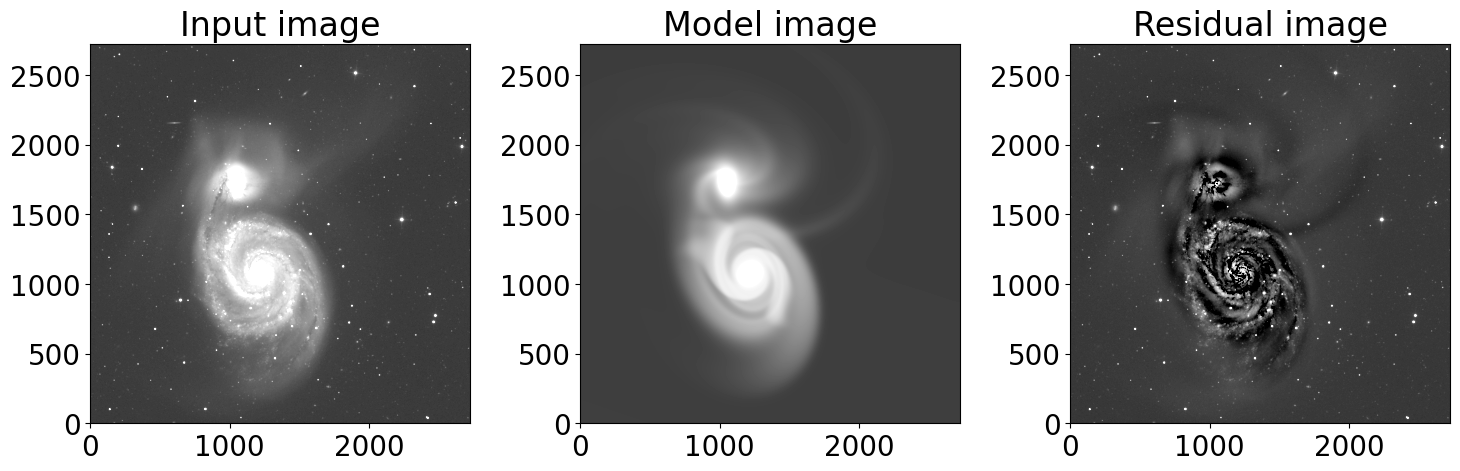

In [28]:
rhdu = fits.open(cwd/DIR_OUTPUT/f"block_{name}-r.fits")

img = rhdu[1].data
mod = rhdu[2].data
res = rhdu[3].data

# Plot the result
inorm = ImageNormalize(img, interval=AsymmetricPercentileInterval(0., 99.0), stretch=AsinhStretch())
mnorm = ImageNormalize(mod, interval=AsymmetricPercentileInterval(0., 99.0), stretch=AsinhStretch())
rnorm = ImageNormalize(res, interval=AsymmetricPercentileInterval(0., 99.0), stretch=AsinhStretch())

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
im = ax[0].imshow(img, origin="lower", cmap="gray", norm=inorm)
mm = ax[1].imshow(mod, origin="lower", cmap="gray", norm=inorm)
rm = ax[2].imshow(res, origin="lower", cmap="gray", norm=inorm)

ax[0].set_title("Input image")
ax[1].set_title("Model image")
ax[2].set_title("Residual image")

fig.tight_layout()

In [29]:
from photutils.aperture import CircularAnnulus, aperture_photometry, ApertureStats

from photutils.isophote import EllipseGeometry
from photutils.isophote import Ellipse

r_e = float(rhdu[2].header['3_RE'][:7])
print(r_e)

ehdu = fits.open(cwd/DIR_INPUT/f"sigma_{name}-r.fits")
eimg = ehdu[0].data

ann = CircularAnnulus((x_a, y_a), r_in=r_e, r_out=r_e+r_e/10.)
ptab = aperture_photometry(img, ann)
astat = ApertureStats(img, ann, error=eimg)
astat.to_table()

417.393


id,xcentroid,ycentroid,sky_centroid,sum,sum_err,sum_aper_area,center_aper_area,min,max,mean,median,mode,std,mad_std,var,biweight_location,biweight_midvariance,fwhm,semimajor_sigma,semiminor_sigma,orientation,eccentricity
,,,,,,pix2,pix2,,,,,,,,,,,pix,pix,pix,deg,
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1181.6833460677544,1014.4054100074512,None,30093.781413107754,9.990323858829099,114936.90281792148,114931.0,-0.011959891766309738,51.8526496887207,0.26175527546576616,0.2512529790401459,0.2302483861889053,0.42416763041637967,0.13755838768291304,0.17991817869304647,0.24673737716292948,0.01534534515364198,719.8337759411461,339.4688184322176,267.6712101662767,-51.26600517798664,0.6150345782474818


(<matplotlib.patches.PathPatch at 0x7f90e319c910>,)

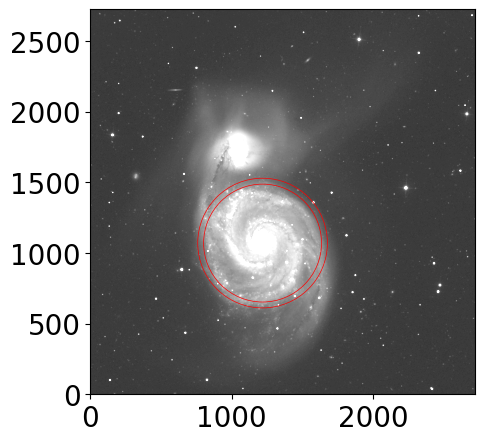

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img, origin="lower", cmap="gray", norm=inorm)
ann.plot(ax=ax, color="red", lw=0.5)

(32.0, 15.0)

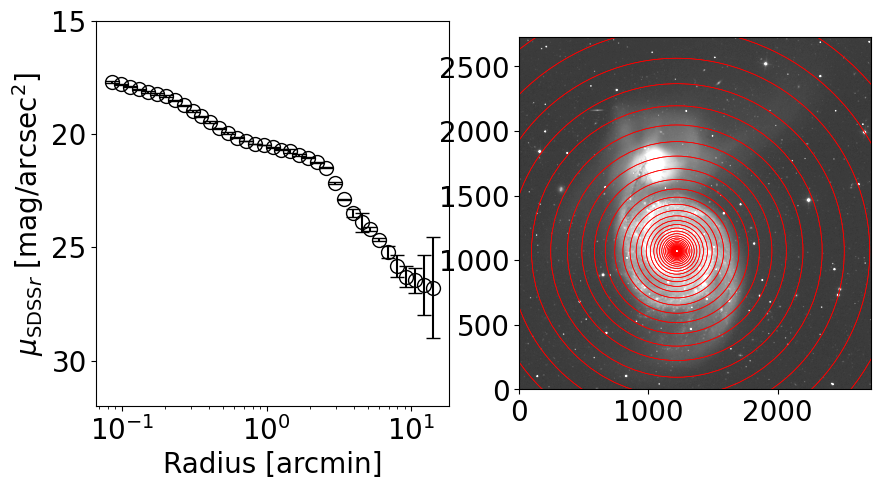

In [51]:
ZP = 22.5
r = np.logspace(np.log10(0.08*60/SCALE), np.log10(20.0*60/SCALE), 40)

def sersic_profile(r, mu_e, r_e, n):
    return mu_e + 8.325*((r/r_e)**(1./n) - 1.)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[1].imshow(img, origin="lower", cmap="gray", norm=inorm)
mu, muerr = [], []
for i in range(len(r)-1):
    ann = CircularAnnulus((x_a, y_a), r_in=r[i], r_out=r[i+1])
    ann.plot(ax=ax[1], color="red", lw=0.5)
    
    astat = ApertureStats(img, ann, error=eimg)
    _mu = -2.5*np.log10(astat.median) +5*np.log10(SCALE) + ZP # [mag/arcsec^2]
    _ferr = astat.std/np.sqrt(astat.sum_aper_area.value)/SCALE**2 # [nmgy/arcsec^2]
    _muerr = 2.5*_ferr/astat.median/np.log(10)
    
    mu.append(_mu)
    muerr.append(_muerr)
    ax[0].errorbar((r[i]+r[i+1])/2./60*SCALE, _mu, yerr=_muerr, fmt="o",
                   color="black", ms=10, mfc='none', capsize=5)
ax[0].set_xscale("log")
ax[0].set_xlabel("Radius [arcmin]")
ax[0].set_ylabel(r"$\mu_{{\rm SDSS} r}$ [mag/arcsec$^2$]")
ax[0].invert_yaxis()
ax[0].set_ylim(32, 15)
    